In [1]:
%matplotlib inline
import gym.spaces
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import my_acrobot
env = gym.make('MyAcrobot-v0')

from IPython import display
plt.ion()
device = "cuda"

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(6, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
BATCH_SIZE = 1024
GAMMA = 0.999
EPS_START = 0.8
EPS_END = 0.05
EPS_DECAY = 50
TARGET_UPDATE = 10
LEARNING_RATE = 0.01
EPISODE_LENGTH = 100
ACTION_M = 3.0

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(10000)

reward_array = []
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
#             print(state.size())
            temp = policy_net(state)
#             print(temp)
#             print(temp.size())
            return temp.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
#     print(state_batch.size())
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [6]:
num_episodes = 100
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = torch.from_numpy(env.reset(action_m=ACTION_M)).float().to(device).view(1,6)
    reward_curr = 0
    for t in range(EPISODE_LENGTH):
        # Select and perform an action
        action = select_action(state)
        ns, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(ns).float().to(device).view(1,6)
        
        reward_curr += reward
        
        reward = torch.tensor([reward], device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()

    reward_array.append(reward_curr)
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

Complete


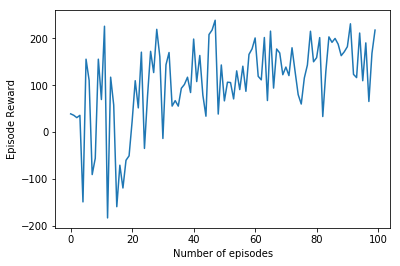

In [7]:
plt.plot(reward_array)
plt.xlabel('Number of episodes')
plt.ylabel('Episode Reward')
plt.show()

In [8]:
state = torch.from_numpy(env.reset(action_m=ACTION_M)).float().to(device).view(1,6)
wait_time = 0.1
total_reward = 0
state_array = np.zeros((EPISODE_LENGTH, 6))

for i in range(EPISODE_LENGTH):
    env.render()
    time.sleep(wait_time)
    action = target_net(state).max(1)[1].view(1, 1)
    ns, reward, done, _ = env.step(action.item())
    state_array[i,:] = ns
    total_reward += reward
    state = torch.from_numpy(ns).float().to(device).view(1,6)
    display.clear_output(wait=True)
    print(reward)
    
# env.close()
print('Reward:', total_reward)

-1.250122680473273
Reward: 229.7795583664618
